## 1. Setup and Imports

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import os
from collections import Counter
import heapq
import pickle
from tqdm import tqdm
import time

# Set random seed for reproducibility
np.random.seed(42)

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

## 2. Configuration

Update these settings based on your video and requirements.

In [44]:
# Video properties 
VIDEO_NAME = "Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv"  # For saving results
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1080
FPS = 120

# Processing parameters
BLOCK_SIZE = 8  # 8x8 blocks (standard)
TARGET_RESOLUTION = (352, 288)  # Downsample to CIF for faster processing
# Alternative: (1920, 1080) for full HD, (640, 480) for intermediate

# RVQ parameters
CODEBOOK_SIZE = 256  # Number of codewords per stage
NUM_STAGES = 3  # Number of RVQ refinement stages
MAX_ITERATIONS = 100  # For codebook training

# Number of frames
NUM_FRAMES = 100

print("Configuration:")
print(f"  Video: {VIDEO_NAME}")
print(f"  Original Resolution: {ORIGINAL_WIDTH}×{ORIGINAL_HEIGHT}")
print(f"  Target Resolution: {TARGET_RESOLUTION[0]}×{TARGET_RESOLUTION[1]}")
print(f"  Block Size: {BLOCK_SIZE}×{BLOCK_SIZE}")
print(f"  RVQ Stages: {NUM_STAGES}")
print(f"  Codebook Size: {CODEBOOK_SIZE}")
print(f"  Frames to Process: {NUM_FRAMES}")

Configuration:
  Video: Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
  Original Resolution: 1920×1080
  Target Resolution: 352×288
  Block Size: 8×8
  RVQ Stages: 3
  Codebook Size: 256
  Frames to Process: 100


## 3. Load Pre-extracted YUV Frames

If you've already loaded frames using `working_with_yuv.ipynb`, you can either:
1. Copy the `yuv_frames` variable here
2. Re-load from the YUV file
3. Load from saved images

In [45]:
def load_yuv420_file(filepath, width, height, num_frames=None, start_frame=0):
    """
    Load YUV 4:2:0 file.
    """
    y_size = width * height
    u_size = (width // 2) * (height // 2)
    v_size = u_size
    frame_size = y_size + u_size + v_size
    
    file_size = os.path.getsize(filepath)
    total_frames = file_size // frame_size
    
    print(f"\nLoading YUV file: {filepath}")
    print(f"  File size: {file_size / (1024*1024):.2f} MB")
    print(f"  Total frames available: {total_frames}")
    
    if num_frames is None:
        num_frames = total_frames - start_frame
    else:
        num_frames = min(num_frames, total_frames - start_frame)
    
    print(f"  Loading frames {start_frame} to {start_frame + num_frames - 1}")
    
    frames_yuv = []
    
    with open(filepath, 'rb') as f:
        f.seek(start_frame * frame_size)
        
        for i in tqdm(range(num_frames), desc="Loading frames"):
            frame_data = f.read(frame_size)
            
            if len(frame_data) < frame_size:
                print(f"  Warning: Incomplete frame {i}, stopping.")
                break
            
            frame_array = np.frombuffer(frame_data, dtype=np.uint8)
            
            y = frame_array[:y_size].reshape(height, width)
            u = frame_array[y_size:y_size+u_size].reshape(height//2, width//2)
            v = frame_array[y_size+u_size:].reshape(height//2, width//2)
            
            frames_yuv.append({
                'Y': y.astype(np.float32),
                'U': u.astype(np.float32),
                'V': v.astype(np.float32)
            })
    
    print(f"Successfully loaded {len(frames_yuv)} frames")
    return frames_yuv


# Load YUV frames
YUV_FILE_PATH = "Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv"

if os.path.exists(YUV_FILE_PATH):
    yuv_frames = load_yuv420_file(
        YUV_FILE_PATH,
        width=ORIGINAL_WIDTH,
        height=ORIGINAL_HEIGHT,
        num_frames=NUM_FRAMES,
        start_frame=0
    )
else:
    print(f" File not found: {YUV_FILE_PATH}")


Loading YUV file: Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
  File size: 1779.79 MB
  Total frames available: 600
  Loading frames 0 to 99


Loading frames: 100%|██████████| 100/100 [00:00<00:00, 148.22it/s]

Successfully loaded 100 frames


## 4. Preprocessing Module

In [46]:
class VideoPreprocessor:
    """
    Handles video preprocessing for RVQ compression.
    """
    
    def __init__(self, block_size: int = 8, target_resolution: Tuple[int, int] = None):
        self.block_size = block_size
        self.target_resolution = target_resolution
    
    def resize_yuv_frames(self, yuv_frames: List[Dict], 
                         target_size: Tuple[int, int]) -> List[Dict]:
        """
        Resize YUV frames to target resolution.
        """
        print(f"\nResizing frames to {target_size[0]}×{target_size[1]}...")
        resized_frames = []
        
        for frame_yuv in tqdm(yuv_frames, desc="Resizing"):
            # Resize Y channel
            y_resized = cv2.resize(
                frame_yuv['Y'].astype(np.float32),
                target_size,
                interpolation=cv2.INTER_LINEAR
            )
            
            # Resize U and V channels (half resolution for 4:2:0)
            u_size = (target_size[0] // 2, target_size[1] // 2)
            u_resized = cv2.resize(
                frame_yuv['U'].astype(np.float32),
                u_size,
                interpolation=cv2.INTER_LINEAR
            )
            v_resized = cv2.resize(
                frame_yuv['V'].astype(np.float32),
                u_size,
                interpolation=cv2.INTER_LINEAR
            )
            
            resized_frames.append({
                'Y': y_resized,
                'U': u_resized,
                'V': v_resized
            })
        
        print(f" Resized {len(resized_frames)} frames")
        return resized_frames
    
    def partition_into_blocks(self, frame: np.ndarray) -> np.ndarray:
        """
        Partition a frame into non-overlapping blocks.
        """
        height, width = frame.shape
        bs = self.block_size
        
        # Ensure dimensions are divisible by block_size
        h_blocks = height // bs
        w_blocks = width // bs
        
        # Truncate if needed
        frame = frame[:h_blocks*bs, :w_blocks*bs]
        
        # Reshape into blocks
        blocks = frame.reshape(h_blocks, bs, w_blocks, bs)
        blocks = blocks.swapaxes(1, 2)
        
        return blocks
    
    def blocks_to_frame(self, blocks: np.ndarray) -> np.ndarray:
        """
        Reconstruct frame from blocks.
        """
        h_blocks, w_blocks, bs, _ = blocks.shape
        blocks = blocks.swapaxes(1, 2)
        frame = blocks.reshape(h_blocks * bs, w_blocks * bs)
        return frame


# Initialize preprocessor
preprocessor = VideoPreprocessor(
    block_size=BLOCK_SIZE,
    target_resolution=TARGET_RESOLUTION
)

## 5. Apply Preprocessing

In [47]:
# Resize frames if needed
if TARGET_RESOLUTION != (ORIGINAL_WIDTH, ORIGINAL_HEIGHT):
    yuv_frames_processed = preprocessor.resize_yuv_frames(yuv_frames, TARGET_RESOLUTION)
else:
    yuv_frames_processed = yuv_frames
    print(" Using original resolution (no resizing)")

print(f"\nProcessed {len(yuv_frames_processed)} frames")
print(f"Y channel shape: {yuv_frames_processed[0]['Y'].shape}")
print(f"U channel shape: {yuv_frames_processed[0]['U'].shape}")
print(f"V channel shape: {yuv_frames_processed[0]['V'].shape}")


Resizing frames to 352×288...


Resizing: 100%|██████████| 100/100 [00:00<00:00, 157.96it/s]

 Resized 100 frames

Processed 100 frames
Y channel shape: (288, 352)
U channel shape: (144, 176)
V channel shape: (144, 176)


## 6. Extract Training Blocks

Extract blocks from Y channel for codebook training.

In [48]:
print("\nExtracting training blocks from Y channel...")

all_training_blocks = []

for frame_yuv in tqdm(yuv_frames_processed, desc="Extracting blocks"):
    y_channel = frame_yuv['Y']
    blocks = preprocessor.partition_into_blocks(y_channel)
    
    # Flatten blocks for training
    h_blocks, w_blocks, bs, _ = blocks.shape
    for i in range(h_blocks):
        for j in range(w_blocks):
            all_training_blocks.append(blocks[i, j])

training_blocks = np.array(all_training_blocks)

print(f"\n Extracted {training_blocks.shape[0]} training blocks")
print(f"   Block shape: {training_blocks.shape[1:]}")
print(f"   Total training samples: {training_blocks.shape[0]}")
print(f"   Memory size: {training_blocks.nbytes / (1024*1024):.2f} MB")


Extracting training blocks from Y channel...


Extracting blocks: 100%|██████████| 100/100 [00:00<00:00, 1298.25it/s]


 Extracted 158400 training blocks
   Block shape: (8, 8)
   Total training samples: 158400
   Memory size: 38.67 MB


## 7. Visualize Sample Frames

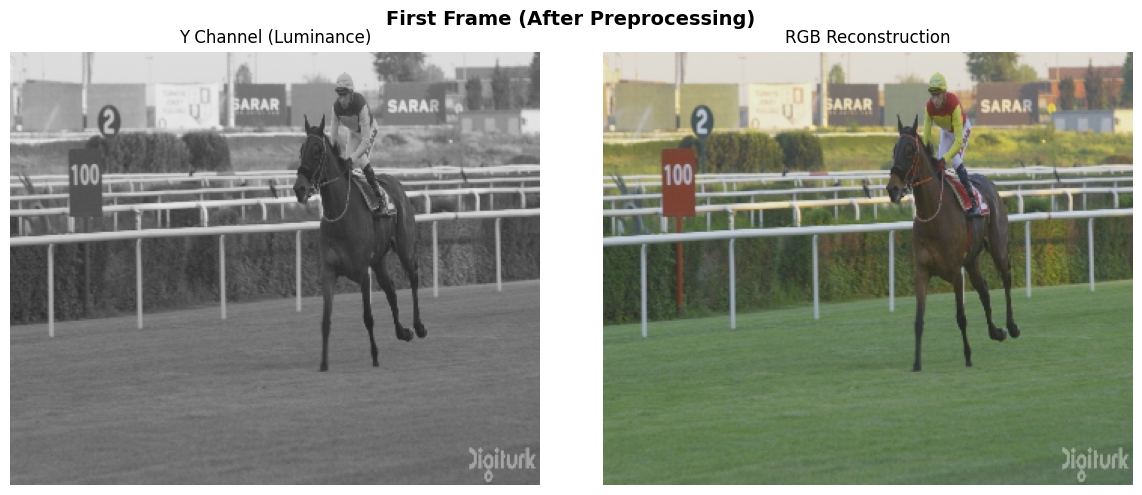

In [49]:
def visualize_yuv_frame(yuv_dict, title="Frame"):
    """
    Visualize Y channel and RGB reconstruction.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Y channel
    axes[0].imshow(yuv_dict['Y'], cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Y Channel (Luminance)')
    axes[0].axis('off')
    
    # RGB reconstruction
    y = np.clip(yuv_dict['Y'], 0, 255).astype(np.uint8)
    u = np.clip(yuv_dict['U'], 0, 255).astype(np.uint8)
    v = np.clip(yuv_dict['V'], 0, 255).astype(np.uint8)
    
    height, width = y.shape
    u_up = cv2.resize(u, (width, height), interpolation=cv2.INTER_LINEAR)
    v_up = cv2.resize(v, (width, height), interpolation=cv2.INTER_LINEAR)
    
    yuv = cv2.merge([y, u_up, v_up])
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    
    axes[1].imshow(rgb)
    axes[1].set_title('RGB Reconstruction')
    axes[1].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize first frame
if len(yuv_frames_processed) > 0:
    visualize_yuv_frame(yuv_frames_processed[0], title="First Frame (After Preprocessing)")

## 8. RVQ Encoder Implementation

In [50]:
class RVQEncoder:
    """
    Residual Vector Quantization Encoder.
    Baseline version: codebook training with plain LBG (no sklearn KMeans).
    """
    
    def __init__(self, codebook_size: int = 256, num_stages: int = 3, 
                 vector_dim: int = 64, max_iterations: int = 100):
        self.codebook_size = codebook_size
        self.num_stages = num_stages
        self.vector_dim = vector_dim
        self.max_iterations = max_iterations
        self.codebooks = []

    # ---------- NEW: pure NumPy LBG (k-means) implementation ----------
    def _lbg_train(self, training_vectors: np.ndarray,
                codebook_size: int = None,
                eps: float = 1e-3,
                batch_size: int = 1024) -> np.ndarray:
        """
        Train codebook using Lloyd/LBG algorithm implemented with NumPy.
        Uses batching to avoid huge (N, K, D) allocations.
        """
        if codebook_size is None:
            codebook_size = self.codebook_size

        N, D = training_vectors.shape

        # Initialize codebook: pick random training samples
        indices = np.random.choice(N, size=codebook_size, replace=False)
        codebook = training_vectors[indices].copy()

        for it in range(self.max_iterations):
            # ----- ASSIGNMENT STEP (batched) -----
            labels = np.empty(N, dtype=np.int32)

            for start in range(0, N, batch_size):
                end = min(start + batch_size, N)
                Xb = training_vectors[start:end]  # (B, D)

                # distances: (B, K)
                diff = Xb[:, None, :] - codebook[None, :, :]
                dists = np.sum(diff * diff, axis=2)
                labels[start:end] = np.argmin(dists, axis=1)

            # ----- UPDATE STEP -----
            new_codebook = np.zeros_like(codebook)
            counts = np.zeros(codebook_size, dtype=np.int64)

            for n in range(N):
                k = labels[n]
                new_codebook[k] += training_vectors[n]
                counts[k] += 1

            # Avoid empty clusters
            for k in range(codebook_size):
                if counts[k] > 0:
                    new_codebook[k] /= counts[k]
                else:
                    rand_idx = np.random.randint(0, N)
                    new_codebook[k] = training_vectors[rand_idx]

            # Convergence check
            delta = np.linalg.norm(new_codebook - codebook) / (np.linalg.norm(codebook) + 1e-12)
            codebook = new_codebook

            # Uncomment to see progress
            # print(f"LBG iter {it+1}, delta={delta:.3e}")

            if delta < eps:
                # print(f"  LBG converged in {it+1} iterations (Δ={delta:.2e})")
                break

        return codebook

    # -----------------------------------------------------------------

    # Keep these wrappers so the rest of the code does not break
    def train_codebook_lbg(self, training_vectors: np.ndarray, 
                           codebook_size: int = None) -> np.ndarray:
        """
        Train codebook using LBG algorithm (NumPy implementation).
        """
        if codebook_size is None:
            codebook_size = self.codebook_size
        
        print(f"  Training codebook: {codebook_size} codewords (LBG, no sklearn)")
        return self._lbg_train(training_vectors, codebook_size=codebook_size)

    def train_codebook_kmeans_plus(self, training_vectors: np.ndarray,
                                   codebook_size: int = None) -> np.ndarray:
        """
        For baseline: behave the same as LBG.
        (We keep this function only so existing calls don't break.)
        """
        if codebook_size is None:
            codebook_size = self.codebook_size
        
        print(f"  Training codebook: {codebook_size} codewords (LBG baseline, no K-means++)")
        return self._lbg_train(training_vectors, codebook_size=codebook_size)

    def find_nearest_codeword(self, vector: np.ndarray, 
                              codebook: np.ndarray) -> Tuple[int, np.ndarray]:
        """
        Find nearest codeword using Euclidean distance.
        """
        distances = np.linalg.norm(codebook - vector, axis=1)
        index = np.argmin(distances)
        return index, codebook[index]
    
    def train_multistage_codebooks(self, training_blocks: np.ndarray,
                                   use_kmeans_plus: bool = False):
        """
        Train all RVQ stage codebooks (baseline LBG only).
        The `use_kmeans_plus` flag is ignored for the baseline.
        """
        print(f"\n{'='*60}")
        print(f"Training {self.num_stages}-stage RVQ Codebooks (Baseline LBG)")
        print(f"{'='*60}")
        print(f"Training samples: {training_blocks.shape[0]}")
        print(f"Codebook size: {self.codebook_size}")
        
        # Flatten blocks
        num_blocks = training_blocks.shape[0]
        training_vectors = training_blocks.reshape(num_blocks, -1)
        
        self.codebooks = []
        residuals = training_vectors.copy()
        
        for stage in range(self.num_stages):
            print(f"\n--- Stage {stage + 1}/{self.num_stages} ---")
            start_time = time.time()
            
            # Train codebook (always LBG baseline)
            codebook = self.train_codebook_lbg(residuals)
            self.codebooks.append(codebook)
            
            # Compute residuals for next stage
            new_residuals = []
            for vector in residuals:
                _, codeword = self.find_nearest_codeword(vector, codebook)
                residual = vector - codeword
                new_residuals.append(residual)
            
            residuals = np.array(new_residuals)
            
            # Metrics
            mse = np.mean(residuals ** 2)
            elapsed = time.time() - start_time
            
            print(f"  MSE: {mse:.4f}")
            print(f"  Time: {elapsed:.2f}s")
        
        print(f"\n{'='*60}")
        print(" Codebook training complete!")
        print(f"{'='*60}")
    
    def encode_block(self, block: np.ndarray, 
                     num_stages: int = None) -> Tuple[List[int], np.ndarray]:
        """
        Encode a single block using multi-stage RVQ.
        """
        if num_stages is None:
            num_stages = self.num_stages
        
        vector = block.flatten()
        indices = []
        reconstruction = np.zeros_like(vector)
        residual = vector.copy()
        
        for stage in range(num_stages):
            idx, codeword = self.find_nearest_codeword(residual, self.codebooks[stage])
            indices.append(idx)
            reconstruction += codeword
            residual -= codeword
        
        reconstructed_block = reconstruction.reshape(block.shape)
        return indices, reconstructed_block
    
    def encode_frame(self, frame_blocks: np.ndarray) -> Tuple[List, np.ndarray]:
        """
        Encode all blocks in a frame.
        """
        h_blocks, w_blocks, bs, _ = frame_blocks.shape
        all_indices = []
        reconstructed_blocks = np.zeros_like(frame_blocks)
        
        for i in range(h_blocks):
            for j in range(w_blocks):
                block = frame_blocks[i, j]
                indices, recon_block = self.encode_block(block)
                all_indices.append(indices)
                reconstructed_blocks[i, j] = recon_block
        
        return all_indices, reconstructed_blocks
    
    def save_codebooks(self, filepath: str):
        """Save codebooks."""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'codebooks': self.codebooks,
                'codebook_size': self.codebook_size,
                'num_stages': self.num_stages,
                'vector_dim': self.vector_dim
            }, f)
        print(f" Codebooks saved: {filepath}")
    
    def load_codebooks(self, filepath: str):
        """Load codebooks."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.codebooks = data['codebooks']
        self.codebook_size = data['codebook_size']
        self.num_stages = data['num_stages']
        self.vector_dim = data['vector_dim']
        print(f" Codebooks loaded: {filepath}")


## 9. Train RVQ Codebooks

This is the most time-consuming step. It trains codebooks for each RVQ stage.

In [51]:
# Ensure output directory exists
codebook_filename = f"models/rvq_codebooks_{VIDEO_NAME}_s{NUM_STAGES}_c{CODEBOOK_SIZE}.pkl"
os.makedirs(os.path.dirname(codebook_filename), exist_ok=True)

# Initialize encoder
rvq_encoder = RVQEncoder(
    codebook_size=CODEBOOK_SIZE,
    num_stages=NUM_STAGES,
    vector_dim=BLOCK_SIZE * BLOCK_SIZE,
    max_iterations=MAX_ITERATIONS
)

# Train codebooks
# Set use_kmeans_plus=True to test the enhanced method
MAX_TRAIN_VECTORS = 20000  # you can tune this (10k–50k typical)

num_blocks = training_blocks.shape[0]
print(f"Total training blocks available: {num_blocks}")

if num_blocks > MAX_TRAIN_VECTORS:
    idx = np.random.choice(num_blocks, size=MAX_TRAIN_VECTORS, replace=False)
    training_blocks_small = training_blocks[idx]
    print(f"Subsampled to {training_blocks_small.shape[0]} blocks for codebook training")
else:
    training_blocks_small = training_blocks
    print("Using all blocks for codebook training")

# Train codebooks
rvq_encoder.train_multistage_codebooks(training_blocks_small, use_kmeans_plus=False)

# Save codebooks
rvq_encoder.save_codebooks(codebook_filename)

Total training blocks available: 158400
Subsampled to 20000 blocks for codebook training

Training 3-stage RVQ Codebooks (Baseline LBG)
Training samples: 20000
Codebook size: 256

--- Stage 1/3 ---
  Training codebook: 256 codewords (LBG, no sklearn)
  MSE: 122.5168
  Time: 54.88s

--- Stage 2/3 ---
  Training codebook: 256 codewords (LBG, no sklearn)
  MSE: 63.1300
  Time: 101.41s

--- Stage 3/3 ---
  Training codebook: 256 codewords (LBG, no sklearn)
  MSE: 41.6720
  Time: 55.55s

 Codebook training complete!
 Codebooks saved: models/rvq_codebooks_Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv_s3_c256.pkl


## 10. Huffman Entropy Coder & Packetizer

In [52]:
class HuffmanNode:
    def __init__(self, symbol=None, freq=0, left=None, right=None):
        self.symbol = symbol
        self.freq = freq
        self.left = left
        self.right = right
    
    def __lt__(self, other):
        return self.freq < other.freq


class HuffmanCoder:
    """
    Huffman entropy coder.
    """
    
    def __init__(self):
        self.huffman_tree = None
        self.codes = {}
        self.reverse_codes = {}
    
    def build_huffman_tree(self, symbols: List[int]):
        """
        Build Huffman tree from symbol frequencies.
        """
        freq_dict = Counter(symbols)
        heap = [HuffmanNode(symbol=sym, freq=freq) 
                for sym, freq in freq_dict.items()]
        heapq.heapify(heap)
        
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            merged = HuffmanNode(freq=left.freq + right.freq,
                               left=left, right=right)
            heapq.heappush(heap, merged)
        
        self.huffman_tree = heap[0] if heap else None
        self._generate_codes(self.huffman_tree, "")
        
        print(f"\nHuffman coding:")
        print(f"  Unique symbols: {len(self.codes)}")
        print(f"  Avg code length: {self._average_code_length(symbols):.2f} bits")
    
    def _generate_codes(self, node: HuffmanNode, code: str):
        if node is None:
            return
        if node.symbol is not None:
            self.codes[node.symbol] = code if code else "0"
            self.reverse_codes[code if code else "0"] = node.symbol
            return
        self._generate_codes(node.left, code + "0")
        self._generate_codes(node.right, code + "1")
    
    def encode(self, symbols: List[int]) -> str:
        if not self.codes:
            self.build_huffman_tree(symbols)
        return ''.join(self.codes.get(sym, '0') for sym in symbols)
    
    def decode(self, bitstring: str) -> List[int]:
        decoded = []
        current_code = ""
        for bit in bitstring:
            current_code += bit
            if current_code in self.reverse_codes:
                decoded.append(self.reverse_codes[current_code])
                current_code = ""
        return decoded
    
    def _average_code_length(self, symbols: List[int]) -> float:
        if not symbols:
            return 0.0
        total_bits = sum(len(self.codes[sym]) for sym in symbols)
        return total_bits / len(symbols)
    
    def compute_compression_ratio(self, original_symbols: List[int]) -> float:
        original_bits = len(original_symbols) * 8
        compressed_bits = sum(len(self.codes[sym]) for sym in original_symbols)
        return original_bits / compressed_bits if compressed_bits > 0 else 0
    
def flatten_indices(encoded_indices, num_stages: int):
    """
    Flatten list of [num_blocks][num_stages] into a 1D list of ints.
    """
    flat = []
    for block_indices in encoded_indices:
        # block_indices is already a list of length num_stages
        flat.extend(block_indices[:num_stages])
    return flat


def unflatten_indices(flat_indices, h_blocks: int, w_blocks: int, num_stages: int):
    """
    Convert 1D list of indices back into shape [h_blocks][w_blocks][num_stages].
    If flat_indices is too short, pad with zeros. If too long, truncate.
    """
    expected = h_blocks * w_blocks * num_stages
    if len(flat_indices) < expected:
        flat_indices = flat_indices + [0] * (expected - len(flat_indices))
    elif len(flat_indices) > expected:
        flat_indices = flat_indices[:expected]

    arr = np.array(flat_indices, dtype=np.int32)
    arr = arr.reshape(h_blocks, w_blocks, num_stages)
    return arr


def reconstruct_from_indices(indices_reshaped: np.ndarray,
                            rvq_encoder,
                            block_size: int):
    """
    Reconstruct blocks from indices [h_blocks, w_blocks, num_stages]
    using the trained codebooks in rvq_encoder.
    """
    h_blocks, w_blocks, num_stages = indices_reshaped.shape
    blocks = np.zeros((h_blocks, w_blocks, block_size, block_size), dtype=np.float32)

    for i in range(h_blocks):
        for j in range(w_blocks):
            idx_list = indices_reshaped[i, j]  # length = num_stages
            # accumulate codewords
            recon_vec = np.zeros(block_size * block_size, dtype=np.float32)
            for s, idx in enumerate(idx_list):
                # safety: clamp index range
                if s < len(rvq_encoder.codebooks) and 0 <= idx < rvq_encoder.codebooks[s].shape[0]:
                    recon_vec += rvq_encoder.codebooks[s][idx]
            blocks[i, j] = recon_vec.reshape(block_size, block_size)

    return blocks

    

class Packetizer:
    """
    Simple bitstream packetizer for per-frame packets.
    Splits a Huffman bitstring into fixed-size packets with a tiny header.
    """
    def __init__(self, packet_size_bits: int = 2048):
        self.packet_size_bits = packet_size_bits

    def packetize_frame(self, frame_idx: int, bitstring: str):
        """
        Split a frame bitstring into packets.
        Returns a list of dicts with 'header' and 'payload' (bits).
        """
        packets = []
        total_bits = len(bitstring)
        if total_bits == 0:
            return packets

        total_packets = (total_bits + self.packet_size_bits - 1) // self.packet_size_bits

        for pkt_idx in range(total_packets):
            start = pkt_idx * self.packet_size_bits
            end = min(start + self.packet_size_bits, total_bits)
            payload = bitstring[start:end]

            header = {
                'frame_idx': frame_idx,
                'packet_idx': pkt_idx,
                'total_packets': total_packets
            }
            packets.append({
                'header': header,
                'payload': payload
            })
        return packets

    def depacketize_frame(self, packets):
        """
        Reconstruct a bitstring for one frame from received packets.
        Assumes all packets belong to the same frame.
        Missing packets simply mean missing bits (shorter bitstring).
        """
        if not packets:
            return ""

        # Sort by packet index to ensure correct order
        packets_sorted = sorted(packets, key=lambda p: p['header']['packet_idx'])
        return ''.join(p['payload'] for p in packets_sorted)


def simulate_packet_loss(packets, loss_rate: float):
    """
    Simulate packet loss: each packet is dropped with probability loss_rate.
    """
    if loss_rate <= 0.0:
        return packets

    kept = []
    for pkt in packets:
        if np.random.rand() >= loss_rate:
            kept.append(pkt)
    return kept


## 11. Quality Metrics

In [53]:
def compute_psnr(original: np.ndarray, reconstructed: np.ndarray) -> float:
    """
    Compute PSNR in dB.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


def visualize_comparison(original: np.ndarray, reconstructed: np.ndarray, 
                        title: str = "Comparison"):
    """
    Visualize original vs reconstructed frame.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    
    diff = np.abs(original - reconstructed)
    axes[2].imshow(diff, cmap='hot', vmin=0, vmax=50)
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    
    psnr = compute_psnr(original, reconstructed)
    plt.suptitle(f"{title} - PSNR: {psnr:.2f} dB", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 12. Encode and Evaluate Single Frame

Test the complete pipeline on one frame.

In [54]:
# Select test frame
test_frame_idx = 0
test_frame_y = yuv_frames_processed[test_frame_idx]['Y']

print(f"\n{'='*60}")
print(f"Testing on Frame {test_frame_idx}")
print(f"{'='*60}")

# Partition into blocks
frame_blocks = preprocessor.partition_into_blocks(test_frame_y)
print(f"Frame shape: {test_frame_y.shape}")
print(f"Blocks shape: {frame_blocks.shape}")
print(f"Total blocks: {frame_blocks.shape[0] * frame_blocks.shape[1]}")

# Encode
print("\nEncoding...")
start_time = time.time()
encoded_indices, reconstructed_blocks = rvq_encoder.encode_frame(frame_blocks)
encoding_time = time.time() - start_time

print(f" Encoded in {encoding_time:.2f}s")
print(f"   {len(encoded_indices)} blocks encoded")
print(f"   {len(encoded_indices[0])} indices per block")

# # Reconstruct frame
# reconstructed_frame = preprocessor.blocks_to_frame(reconstructed_blocks)

# # Quality metrics
# psnr = compute_psnr(test_frame_y, reconstructed_frame)
# print(f"\n Quality Metrics:")
# print(f"   PSNR: {psnr:.2f} dB")

# # Visualize
# visualize_comparison(test_frame_y, reconstructed_frame, f"Frame {test_frame_idx}")


Testing on Frame 0
Frame shape: (288, 352)
Blocks shape: (36, 44, 8, 8)
Total blocks: 1584

Encoding...
 Encoded in 0.18s
   1584 blocks encoded
   3 indices per block


## 13. Apply Entropy Coding


Entropy Coding + Packetization + Channel Simulation
Total indices: 4752

Huffman coding:
  Unique symbols: 254
  Avg code length: 7.47 bits
 Number of packets for frame 0: 18
 Received packets: 17 (loss rate = 2.0%)

 Channel-Aware Quality Metrics:
   PSNR after channel: 14.80 dB


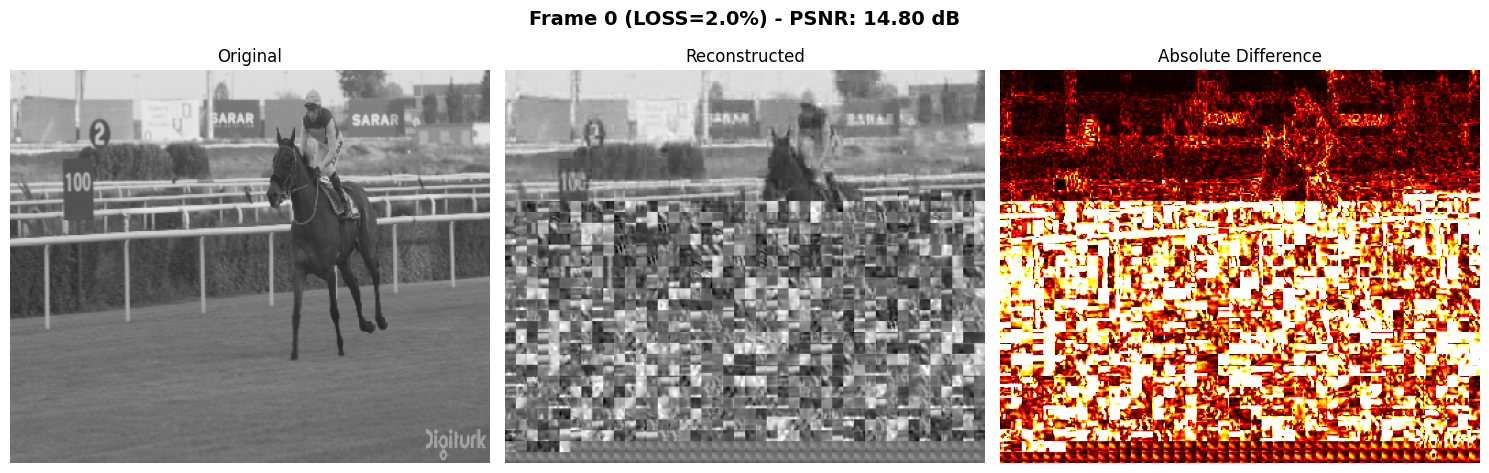


 Compression Statistics:
   Original (indices): 38016 bits (4.75 KB)
   Compressed (Huffman): 35475 bits (4.43 KB)
   Huffman compression: 1.07x

 Overall Frame Compression:
   Original frame: 811008 bits (101.38 KB)
   Compressed: 35475 bits (4.43 KB)
   Overall ratio: 22.86x
   Estimated bitrate: 4257.00 kbps (at 120 fps)


In [55]:
# Flatten indices from RVQ
all_indices = flatten_indices(encoded_indices, NUM_STAGES)

print(f"\n{'='*60}")
print("Entropy Coding + Packetization + Channel Simulation")
print(f"{'='*60}")
print(f"Total indices: {len(all_indices)}")

# Huffman coding
huffman_coder = HuffmanCoder()
encoded_bitstring = huffman_coder.encode(all_indices)

# Packetization + channel
packetizer = Packetizer(packet_size_bits=2048)
LOSS_RATE = 0.02  # for example: 2% packet loss; set 0.0 for no loss

packets = packetizer.packetize_frame(test_frame_idx, encoded_bitstring)
print(f" Number of packets for frame {test_frame_idx}: {len(packets)}")

received_packets = simulate_packet_loss(packets, LOSS_RATE)
print(f" Received packets: {len(received_packets)} (loss rate = {LOSS_RATE*100:.1f}%)")

received_bitstring = packetizer.depacketize_frame(received_packets)

# Decode indices from received bitstring
decoded_indices_flat = huffman_coder.decode(received_bitstring)

# Reshape indices back to [h_blocks, w_blocks, NUM_STAGES]
h_blocks, w_blocks, bs, _ = frame_blocks.shape
decoded_indices_reshaped = unflatten_indices(
    decoded_indices_flat,
    h_blocks=h_blocks,
    w_blocks=w_blocks,
    num_stages=NUM_STAGES
)

# Reconstruct blocks from (possibly corrupted/truncated) indices
reconstructed_blocks_channel = reconstruct_from_indices(
    decoded_indices_reshaped,
    rvq_encoder,
    block_size=BLOCK_SIZE
)

# Reconstruct full frame
reconstructed_frame_channel = preprocessor.blocks_to_frame(reconstructed_blocks_channel)

# Quality metrics under channel
psnr_channel = compute_psnr(test_frame_y, reconstructed_frame_channel)

print(f"\n Channel-Aware Quality Metrics:")
print(f"   PSNR after channel: {psnr_channel:.2f} dB")

# Visualize
visualize_comparison(test_frame_y, reconstructed_frame_channel,
                     f"Frame {test_frame_idx} (LOSS={LOSS_RATE*100:.1f}%)")

# Compression statistics (based on full encoded bitstream)
original_bits = len(all_indices) * 8
compressed_bits = len(encoded_bitstring)
compression_ratio_huffman = original_bits / compressed_bits if compressed_bits > 0 else 0.0

print(f"\n Compression Statistics:")
print(f"   Original (indices): {original_bits} bits ({original_bits/8000:.2f} KB)")
print(f"   Compressed (Huffman): {compressed_bits} bits ({compressed_bits/8000:.2f} KB)")
print(f"   Huffman compression: {compression_ratio_huffman:.2f}x")

# Overall compression w.r.t. original frame
original_frame_bits = test_frame_y.size * 8
overall_compression = original_frame_bits / compressed_bits if compressed_bits > 0 else 0.0

print(f"\n Overall Frame Compression:")
print(f"   Original frame: {original_frame_bits} bits ({original_frame_bits/8000:.2f} KB)")
print(f"   Compressed: {compressed_bits} bits ({compressed_bits/8000:.2f} KB)")
print(f"   Overall ratio: {overall_compression:.2f}x")

bitrate_kbps = (compressed_bits * FPS) / 1000 if compressed_bits > 0 else 0.0
print(f"   Estimated bitrate: {bitrate_kbps:.2f} kbps (at {FPS} fps)")


## 14. Process All Frames

In [56]:
print(f"\n{'='*60}")
print(f"Processing All {len(yuv_frames_processed)} Frames (with channel effects)")
print(f"{'='*60}\n")

results = []

# Packetization + channel parameters
packetizer = Packetizer(packet_size_bits=2048)   # tune packet size if you like
LOSS_RATE = 0.02                                 # e.g. 2% packet loss; set 0.0 for no loss

huffman_coder_all = None  # will be built on the first frame

for frame_idx in tqdm(range(len(yuv_frames_processed)), desc="Processing frames"):
    frame_y = yuv_frames_processed[frame_idx]['Y']

    # ---------------- RVQ ENCODING (ideal side) ----------------
    frame_blocks = preprocessor.partition_into_blocks(frame_y)
    encoded_indices, reconstructed_blocks_ideal = rvq_encoder.encode_frame(frame_blocks)

    # Ideal reconstruction (no channel) -- optional, for reference
    ideal_frame = preprocessor.blocks_to_frame(reconstructed_blocks_ideal)
    psnr_ideal = compute_psnr(frame_y, ideal_frame)

    # ---------------- FLATTEN INDICES FOR ENTROPY CODING ----------------
    all_indices = flatten_indices(encoded_indices, NUM_STAGES)

    # Build Huffman tree on first frame, reuse for all others
    if frame_idx == 0:
        huffman_coder_all = HuffmanCoder()
        huffman_coder_all.build_huffman_tree(all_indices)

    # Huffman encode full index stream for this frame
    encoded_bitstring = huffman_coder_all.encode(all_indices)

    # ---------------- PACKETIZATION + CHANNEL SIMULATION ----------------
    packets = packetizer.packetize_frame(frame_idx, encoded_bitstring)
    received_packets = simulate_packet_loss(packets, LOSS_RATE)
    received_bitstring = packetizer.depacketize_frame(received_packets)

    # ---------------- HUFFMAN DECODE FROM RECEIVED BITSTREAM ----------------
    decoded_indices_flat = huffman_coder_all.decode(received_bitstring)

    # Reshape decoded indices back to [h_blocks, w_blocks, NUM_STAGES]
    h_blocks, w_blocks, bs, _ = frame_blocks.shape
    decoded_indices_reshaped = unflatten_indices(
        decoded_indices_flat,
        h_blocks=h_blocks,
        w_blocks=w_blocks,
        num_stages=NUM_STAGES
    )

    # ---------------- RECONSTRUCT FROM CHANNEL-AFFECTED INDICES ----------------
    reconstructed_blocks_channel = reconstruct_from_indices(
        decoded_indices_reshaped,
        rvq_encoder,
        block_size=BLOCK_SIZE
    )
    reconstructed_frame_channel = preprocessor.blocks_to_frame(reconstructed_blocks_channel)

    # PSNR after channel (this is what will show up in your plots)
    psnr_channel = compute_psnr(frame_y, reconstructed_frame_channel)

    # ---------------- STATISTICS ----------------
    original_bits = frame_y.size * 8
    compressed_bits = len(encoded_bitstring)  # size of full compressed frame bitstream
    compression_ratio = original_bits / compressed_bits if compressed_bits > 0 else 0.0
    bitrate = (compressed_bits * FPS) / 1000 if compressed_bits > 0 else 0.0

    results.append({
        'frame': frame_idx,
        'psnr': psnr_channel,         # channel-aware PSNR
        'psnr_ideal': psnr_ideal,     # ideal (no channel) PSNR for reference
        'original_bits': original_bits,
        'compressed_bits': compressed_bits,
        'compression_ratio': compression_ratio,
        'bitrate_kbps': bitrate,
        'num_packets': len(packets),
        'received_packets': len(received_packets)
    })

print(f"\n Processed {len(results)} frames with LOSS_RATE = {LOSS_RATE*100:.1f}%")



Processing All 100 Frames (with channel effects)



Processing frames:   0%|          | 0/100 [00:00<?, ?it/s]


Huffman coding:
  Unique symbols: 254


Processing frames:   1%|          | 1/100 [00:00<00:19,  5.07it/s]

  Avg code length: 7.47 bits


Processing frames: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


 Processed 100 frames with LOSS_RATE = 2.0%


## 15. Results Summary

In [57]:
import pandas as pd
results_filename = f"results/{VIDEO_NAME}_results_s{NUM_STAGES}_c{CODEBOOK_SIZE}.csv"
os.makedirs(os.path.dirname(results_filename), exist_ok=True)

# Create results dataframe
df_results = pd.DataFrame(results)

print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}\n")

print("Per-Frame Results:")
print(df_results.to_string(index=False))

print(f"\n{'='*60}")
print("AVERAGE METRICS")
print(f"{'='*60}")
print(f"Average PSNR: {df_results['psnr'].mean():.2f} dB")
print(f"Min PSNR: {df_results['psnr'].min():.2f} dB")
print(f"Max PSNR: {df_results['psnr'].max():.2f} dB")
print(f"\nAverage Compression Ratio: {df_results['compression_ratio'].mean():.2f}x")
print(f"Average Bitrate: {df_results['bitrate_kbps'].mean():.2f} kbps")
print(f"\nTotal Original Size: {df_results['original_bits'].sum() / (8*1024):.2f} KB")
print(f"Total Compressed Size: {df_results['compressed_bits'].sum() / (8*1024):.2f} KB")
print(f"Overall Compression: {df_results['original_bits'].sum() / df_results['compressed_bits'].sum():.2f}x")

# Save results
df_results.to_csv(results_filename, index=False)
print(f"\n Results saved: {results_filename}")


RESULTS SUMMARY

Per-Frame Results:
 frame      psnr  psnr_ideal  original_bits  compressed_bits  compression_ratio  bitrate_kbps  num_packets  received_packets
     0 30.189896   30.189896         811008            35475          22.861395       4257.00           18                18
     1 14.024668   30.237930         811008            35672          22.735142       4280.64           18                17
     2 12.705049   30.122900         811008            35849          22.622890       4301.88           18                17
     3 18.400791   30.177071         811008            35945          22.562470       4313.40           18                18
     4 15.484274   30.086573         811008            35994          22.531755       4319.28           18                17
     5 14.658223   30.226709         811008            35799          22.654488       4295.88           18                18
     6 14.726416   30.307251         811008            35943          22.563726       43

### Average PSNR values

In [58]:
avg_psnr_channel = df_results['psnr'].mean()
avg_psnr_ideal = df_results['psnr_ideal'].mean()

print(f"\n{'='*60}")
print("AVERAGE PSNR COMPARISON")
print(f"{'='*60}")
print(f"  Mean PSNR (After Channel): {avg_psnr_channel:.2f} dB")
print(f"  Mean PSNR (Ideal, No Loss): {avg_psnr_ideal:.2f} dB")
print(f"  Drop due to Channel Loss: {avg_psnr_ideal - avg_psnr_channel:.2f} dB")



AVERAGE PSNR COMPARISON
  Mean PSNR (After Channel): 15.56 dB
  Mean PSNR (Ideal, No Loss): 30.88 dB
  Drop due to Channel Loss: 15.33 dB


## 16. Visualization: Rate-Distortion Curve

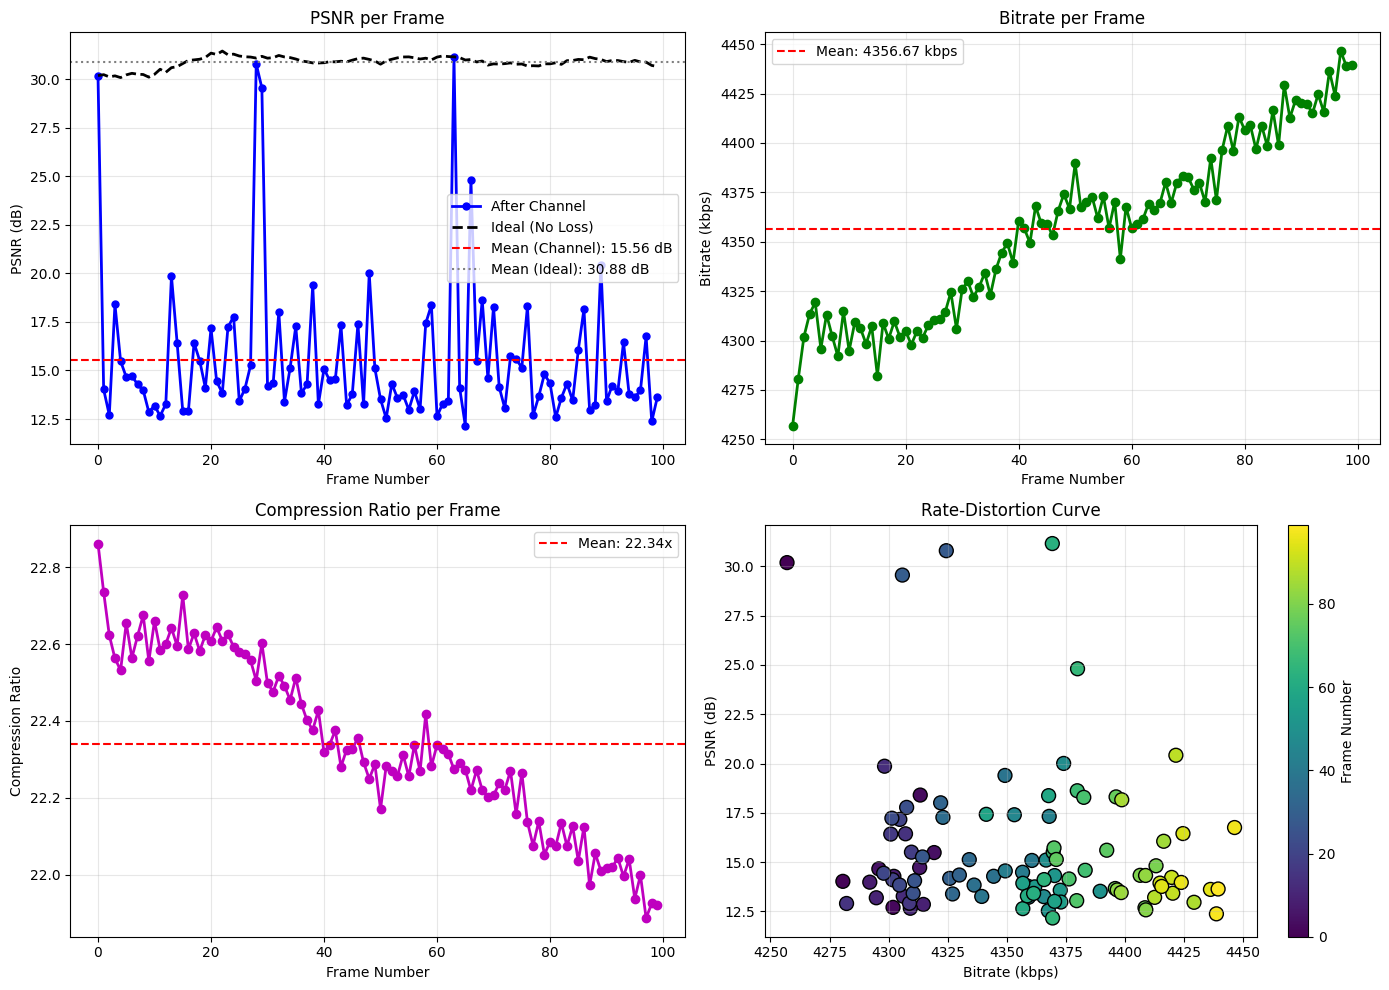

 Plots saved to results/


In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PSNR vs Frame
axes[0, 0].plot(df_results['frame'], df_results['psnr'], 'b-o', linewidth=2, markersize=5, label='After Channel')
axes[0, 0].plot(df_results['frame'], df_results['psnr_ideal'], 'k--', linewidth=2, label='Ideal (No Loss)')

axes[0, 0].set_xlabel('Frame Number')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].set_title('PSNR per Frame')
axes[0, 0].grid(True, alpha=0.3)

# Mean lines
axes[0, 0].axhline(df_results['psnr'].mean(), color='r', linestyle='--', label=f"Mean (Channel): {df_results['psnr'].mean():.2f} dB")
axes[0, 0].axhline(df_results['psnr_ideal'].mean(), color='gray', linestyle=':', label=f"Mean (Ideal): {df_results['psnr_ideal'].mean():.2f} dB")

axes[0, 0].legend()

# Bitrate vs Frame
axes[0, 1].plot(df_results['frame'], df_results['bitrate_kbps'], 'g-o', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Frame Number')
axes[0, 1].set_ylabel('Bitrate (kbps)')
axes[0, 1].set_title('Bitrate per Frame')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(df_results['bitrate_kbps'].mean(), color='r', linestyle='--',
                   label=f"Mean: {df_results['bitrate_kbps'].mean():.2f} kbps")
axes[0, 1].legend()

# Compression Ratio vs Frame
axes[1, 0].plot(df_results['frame'], df_results['compression_ratio'], 'm-o', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Frame Number')
axes[1, 0].set_ylabel('Compression Ratio')
axes[1, 0].set_title('Compression Ratio per Frame')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(df_results['compression_ratio'].mean(), color='r', linestyle='--',
                   label=f"Mean: {df_results['compression_ratio'].mean():.2f}x")
axes[1, 0].legend()

# Rate-Distortion (PSNR vs Bitrate)
axes[1, 1].scatter(df_results['bitrate_kbps'], df_results['psnr'], 
                   c=df_results['frame'], cmap='viridis', s=100, edgecolors='black')
axes[1, 1].set_xlabel('Bitrate (kbps)')
axes[1, 1].set_ylabel('PSNR (dB)')
axes[1, 1].set_title('Rate-Distortion Curve')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Frame Number')

# plt.suptitle(f'Compression Results - {VIDEO_NAME} ({NUM_STAGES} stages, {CODEBOOK_SIZE} codewords)',
#              fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'results/{VIDEO_NAME}_plots_s{NUM_STAGES}_c{CODEBOOK_SIZE}.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print(f" Plots saved to results/")

## 17. Visual Comparison: Multiple Frames

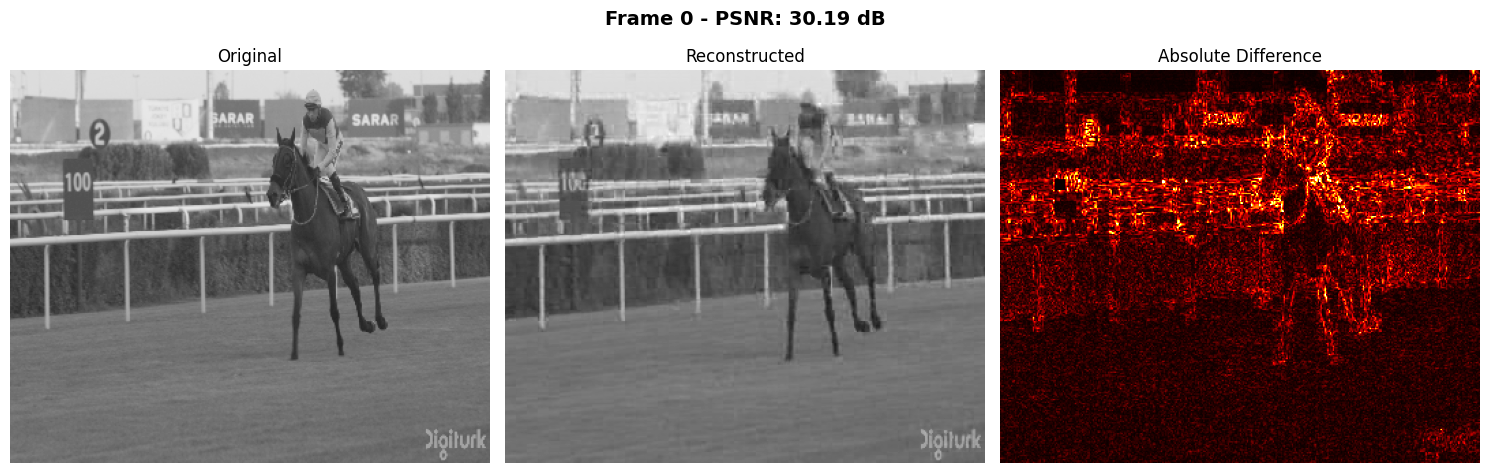

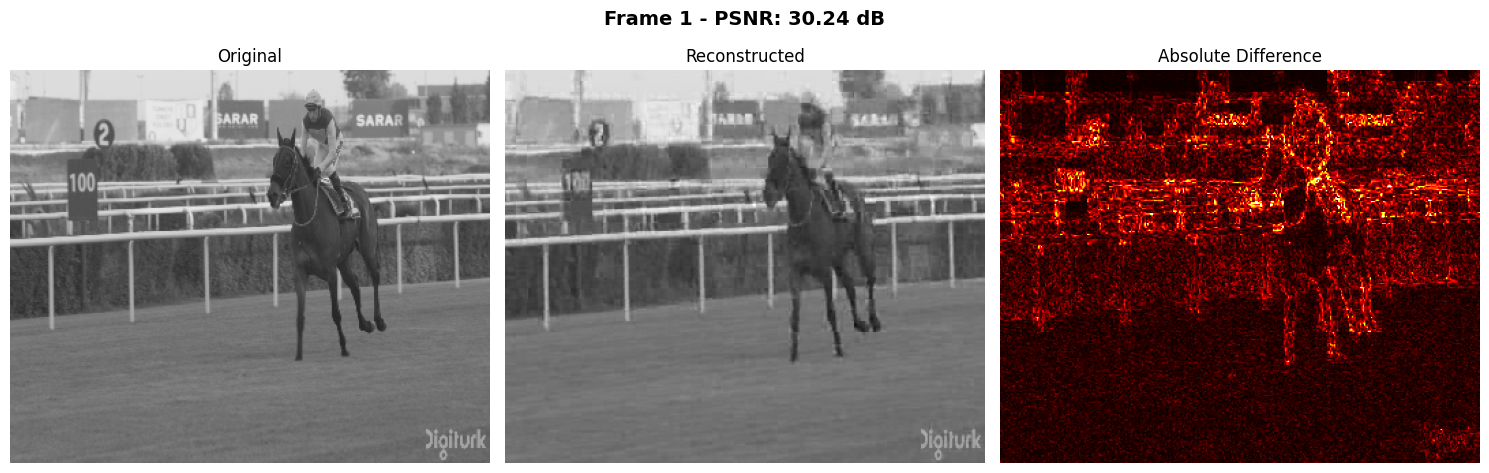

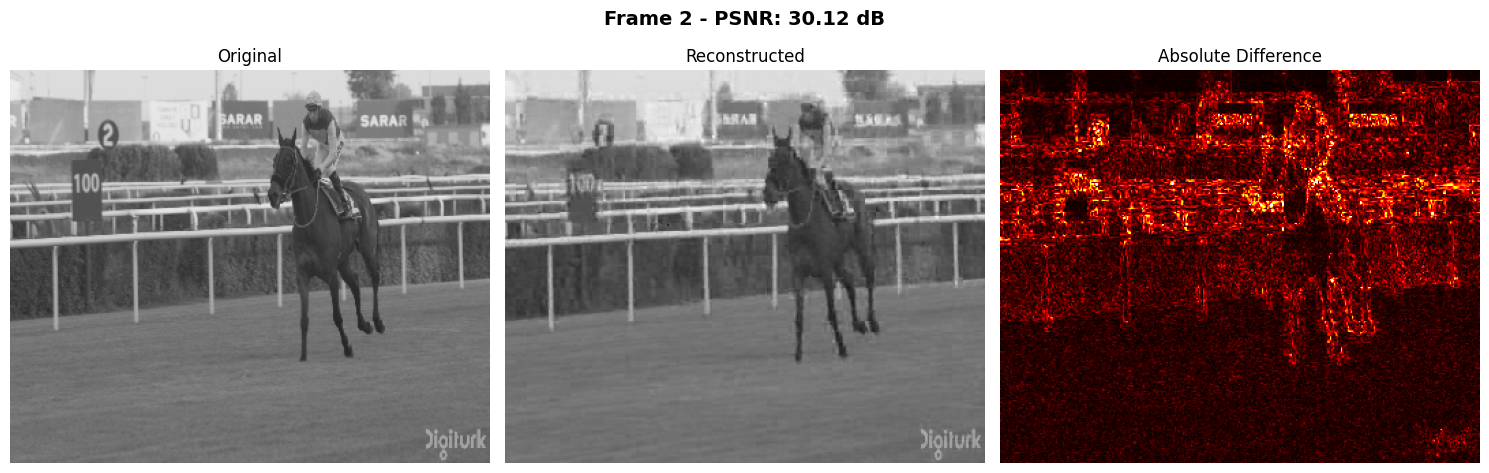

In [60]:
# Show comparison for first few frames
num_frames_to_show = min(3, len(yuv_frames_processed))

for i in range(num_frames_to_show):
    frame_y = yuv_frames_processed[i]['Y']
    frame_blocks = preprocessor.partition_into_blocks(frame_y)
    _, reconstructed_blocks = rvq_encoder.encode_frame(frame_blocks)
    reconstructed_frame = preprocessor.blocks_to_frame(reconstructed_blocks)
    
    visualize_comparison(frame_y, reconstructed_frame, f"Frame {i}")